In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D, RandomRotation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
from sklearn.model_selection import StratifiedKFold
from classification_models.keras import Classifiers

import tensorflow as tf
import sklearn

NUMBER_CLASSES = 4

In [2]:
def create_resnet_model(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [8]:
class RandomSharpenLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomSharpenLayer, self).__init__(**kwargs)
        self.kernel = tf.constant([[0.0, -1.0, 0.0],
                              [-1.0, 5.0, -1.0],
                              [0.0, -1.0, 0.0]], dtype=tf.float32)
        self.kernel = tf.reshape(self.kernel, [3, 3, 1, 1])
        self.kernel = tf.tile(self.kernel, [1, 1, 3, 1]) # for 3 rgb dimensions   

    # def call(self, inputs):
    #     
    #     if tf.random.uniform([], 0, 1) > 0.5:
    #         return tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
    #     else:
    #         return inputs
    
    def call(self, inputs):
        # Generate a random value between 0 and 1
        random_value = tf.random.uniform([], 0, 1)
        
        # Define the condition for applying sharpening
        sharpen_condition = tf.greater(random_value, 0.5)
        
        # Use tf.cond to apply sharpening or not
        return tf.cond(sharpen_condition,
                       lambda: tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME'),
                       lambda: inputs)
        
    def compute_output_shape(self, input_shape):
        return input_shape
        
def create_resnet_model_sharp(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(RandomSharpenLayer())
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

    
    
# with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
#     birne = pickle.load(file)[:6]
# 
# birne = tf.cast(birne, dtype=tf.float32)
# 
# hh = RandomSharpenLayer()
# birnen = hh.call(birne).numpy()
# 
# for i, sub_birne in enumerate(birne.numpy()):
#     cv2.imwrite(f'TEST{i}.png', sub_birne)
#     apfel = birnen[i]
#     cv2.imwrite(f'TEST{i}_adjusted.png', apfel)
#     print(apfel.shape)

In [2]:
# class RandomBlurLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(RandomBlurLayer, self).__init__(**kwargs)
#         self.kernel = tf.constant([[1.0, 2.0, 1.0],
#                                    [2.0, 4.0, 2.0],
#                                    [1.0, 2.0, 1.0]], dtype=tf.float32)
#         self.kernel = self.kernel / 16.0
#         self.kernel = tf.reshape(self.kernel, [3, 3, 1, 1])
#         self.kernel = tf.tile(self.kernel, [1, 1, 3, 1]) # for 3 rgb dimensions   
# 
#     # def call(self, inputs):
#     #     
#     #     if tf.random.uniform([], 0, 1) > 0.5:
#     #         return tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
#     #     else:
#     #         return inputs
#         
#     def call(self, inputs):
#         random_value = tf.random.uniform([], 0, 1)
#         
#         blur_condition = tf.greater(random_value, 0.5)
#         
#         return tf.cond(blur_condition,
#                        lambda: tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME'),
#                        lambda: inputs)
#         
#     def compute_output_shape(self, input_shape):
#         return input_shape

class RandomBlurLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomBlurLayer, self).__init__(**kwargs)
        kernel = [[1.0, 2.0, 1.0], [2.0, 4.0, 2.0], [1.0, 2.0, 1.0]]
        kernel = tf.constant(kernel, dtype=tf.float32) / 16.0
        kernel = tf.reshape(kernel, [3, 3, 1, 1])
        self.kernel = tf.tile(kernel, [1, 1, 3, 1])

    def call(self, inputs):
        return tf.cond(tf.random.uniform([]) > 0.5,
            lambda: tf.nn.depthwise_conv2d(inputs, 
                self.kernel, strides=[1, 1, 1, 1], padding='SAME'),
            lambda: inputs)
        
    def compute_output_shape(self, input_shape):
        return input_shape
        
def create_resnet_model_blur(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(RandomBlurLayer())
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model



with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
    birne = pickle.load(file)[:7]

birne = tf.cast(birne, dtype=tf.float32)

hh = RandomBlurLayer()
birnen = hh.call(birne).numpy()

for i, sub_birne in enumerate(birne.numpy()):
    cv2.imwrite(f'TEST{i}.png', sub_birne)
    apfel = birnen[i]
    cv2.imwrite(f'TEST{i}_adjusted.png', apfel)
    print(apfel.shape)

2025-04-13 19:49:44.002938: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-13 19:49:44.003530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-13 19:49:44.003543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1744566584.005449 5615057 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744566584.007193 5615057 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
[ WARN:0@19.053] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [10]:
def create_resnet_model_contrast(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomContrast((0.7, 1.3)))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [7]:
def create_resnet_model_brightness(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(tf.keras.layers.RandomBrightness(0.3))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [12]:
class RandomNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RandomNoiseLayer, self).__init__(**kwargs)

    def call(self, inputs):
        
        noise = tf.random.normal(shape=tf.shape(inputs)[:-1], mean=0, stddev=tf.random.uniform([], minval=4, maxval=7, dtype=tf.float32))
        noise_rgb = tf.repeat(noise[..., tf.newaxis], 3, axis=-1)
        
        return inputs + noise_rgb
        
def create_resnet_model_noise(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(RandomNoiseLayer())
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

    
    
# with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
#     birne = pickle.load(file)[:7]
# 
# birne = tf.cast(birne, dtype=tf.float32)
# 
# hh = RandomNoiseLayer()
# birnen = hh.call(birne).numpy()
# 
# for i, sub_birne in enumerate(birne.numpy()):
#     cv2.imwrite(f'TEST{i}.png', sub_birne)
#     apfel = birnen[i]
#     cv2.imwrite(f'TEST{i}_adjusted.png', apfel)
#     print(apfel.shape)

In [34]:
def create_resnet_model_allPhotometric(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = True
    
    model = Sequential()
    model.add(RandomNoiseLayer())
    model.add(RandomSharpenLayer())
    # model.add(RandomBlurLayer())
    model.add(tf.keras.layers.RandomContrast((0.7, 1.3)))
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
IMAGE_SIZE = 224
IMAGE_CENTER = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)

def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [15]:
BATCH_SIZE = 16
NUMBER_OF_IMAGES = 20000
IMAGE_SIZE = 224
evaluations={}

with open(f"augmentation_data/images_clean.pkl", "rb") as file:
    images_clean = pickle.load(file)[:100]
with open(f"augmentation_data/labels_clean.pkl", "rb") as file:
    labels_clean = pickle.load(file)[:100]
with open(f"augmentation_data/images_test.pkl", "rb") as file:
    images_test = pickle.load(file)[:100]
with open(f"augmentation_data/labels_test.pkl", "rb") as file:
    labels_test = pickle.load(file)[:100]

In [2]:
with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
    birne1 = pickle.load(file)[:10]
with open(f"augmentation_data/labels_clean_20000.pkl", "rb") as file:
    birne2 = pickle.load(file)[:10]
    
layer = tf.keras.layers.RandomFlip(mode='horizontal')
layer.adapt(birne1)
test = layer(birne1)

2025-03-31 10:40:58.017915: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-31 10:40:58.018005: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-31 10:40:58.018257: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1743410458.018447 2533856 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743410458.018727 2533856 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


KeyboardInterrupt: 

In [8]:
with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
    images_train = pickle.load(file)[:10000]
with open(f"augmentation_data/labels_clean_20000.pkl", "rb") as file:
    labels_train = pickle.load(file)[:10000]

with open(f"augmentation_data/images_val_2000.pkl", "rb") as file:
    images_val = pickle.load(file)
with open(f"augmentation_data/labels_val_2000.pkl", "rb") as file:
    labels_val = pickle.load(file)
val_dataset = create_val_dataset(images_val, labels_val)

with open(f"augmentation_data/images_test_4000.pkl", "rb") as file:
    images_test = pickle.load(file)
with open(f"augmentation_data/labels_test_4000.pkl", "rb") as file:
    labels_test = pickle.load(file)
    
master_evaluations = {}
BATCH_SIZE = 16
IMAGE_SIZE = 224

for aug_idx in range(4, 5):
        
    evaluations = {}
    
    for run in range(5):
    
        tf.keras.backend.clear_session()
           
        train_dataset = create_train_dataset(images_train, labels_train)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        reduceLR_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=1e-7
        )
        
        model = None
        
        if aug_idx == 0:
            model = create_resnet_model(IMAGE_SIZE)
        if aug_idx == 1:
            model = create_resnet_model_sharp(IMAGE_SIZE)
        if aug_idx == 2:
            model = create_resnet_model_blur(IMAGE_SIZE)
        if aug_idx == 3:
            model = create_resnet_model_contrast(IMAGE_SIZE)
        if aug_idx == 4:
            model = create_resnet_model_brightness(IMAGE_SIZE)
        if aug_idx == 5:
            model = create_resnet_model_noise(IMAGE_SIZE)
        if aug_idx == 6:
            model = create_resnet_model_allPhotometric(IMAGE_SIZE)
                            
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping]) #######BIRNE
        
        sub_eval = evaluate_model(model, images_test, labels_test)
        
        evaluations[run] = sub_eval
        print(aug_idx)
        print(evaluations)
        
    master_evaluations[aug_idx] = evaluations

Epoch 1/20


2025-04-03 16:08:36.271922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 233ms/step - auc: 0.6284 - loss: 0.9512 - val_auc: 0.7036 - val_loss: 0.8843
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 208ms/step - auc: 0.6950 - loss: 0.8671 - val_auc: 0.7391 - val_loss: 0.7994
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 218ms/step - auc: 0.7380 - loss: 0.8164 - val_auc: 0.7471 - val_loss: 0.8348
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - auc: 0.7710 - loss: 0.7792 - val_auc: 0.7463 - val_loss: 0.8156
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - auc: 0.8073 - loss: 0.7291 - val_auc: 0.7280 - val_loss: 1.0266
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 244ms/step - auc: 0.8605 - loss: 0.6359 - val_auc: 0.6935 - val_loss: 1.1411
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 242ms/step - auc: 0.9055 - loss: 0.5320 - val_auc: 0.6865 - val_loss: 1.3769
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
4
{0: ([0.7347516988446754, 0.7378211726951223, 0.5823621365613553, 0.66414024800808], 0.28897946738504016, 0.6665

In [10]:
#10000 samples, ES 5

evaluations_original = {0: ([0.7513445745270586, 0.8103735351634511, 0.5864613291981455, 0.6942758949612838], 0.2609003499725249, 0.66575), 1: ([0.7363036957902428, 0.7530837887980746, 0.6027894631410257, 0.6842621479070812], 0.30502404909332154, 0.66775), 2: ([0.7606895969396933, 0.7646785987122122, 0.6102674994276557, 0.6880344518011448], 0.2751474214087549, 0.66575)}


evaluations_sharpness = {0: ([0.7444638405821044, 0.7953026419412974, 0.5756008721096612, 0.6876705756929637], 0.2560332356626861, 0.6635), 1: ([0.7539850802706403, 0.8068790169630505, 0.5794753748855311, 0.6847786443721243], 0.2772852083417099, 0.6695), 2: ([0.7276938298255082, 0.7808172409012745, 0.5759840745192308, 0.673952278083268], 0.28072248636296626, 0.66725), 3: ([0.7297864099768346, 0.7702370874639782, 0.570750253977793, 0.6614835596453822], 0.25697700132684653, 0.66675), 4: ([0.755196574042461, 0.7713763638133386, 0.5875610798706502, 0.6782469700370328], 0.26538115844423893, 0.66825)}


evaluations_blurr = {0: ([0.7361403276907093, 0.7853750836944114, 0.5654989948202839, 0.6385552968241499], 0.2811042778355361, 0.66775), 1: ([0.7419132790730971, 0.8031175615209227, 0.5866936205070972, 0.6911697620917967], 0.27039297776526877, 0.663), 2: ([0.7240318145606865, 0.7732102669077459, 0.5742348471840659, 0.6245637414431601], 0.27953659633709943, 0.6675), 3: ([0.746559174128367, 0.8052036539431497, 0.5877971719036172, 0.687733980473572], 0.27748746029512283, 0.6695), 4: ([0.7459479204525847, 0.7904011727541139, 0.5912010556175595, 0.6907887723038941], 0.2776916538146359, 0.67025)}


evaluations_contrast = {0: ([0.7338981464145292, 0.8074799944547844, 0.5697142213255495, 0.6581663113006397], 0.27420242618578533, 0.6685), 1: ([0.731713786432004, 0.7989770846913704, 0.5614948202838828, 0.6753045393334082], 0.25057446423545493, 0.665), 2: ([0.7221200406768211, 0.7094439741498565, 0.5854407230139652, 0.6869377735383234], 0.2564558329312586, 0.66625), 3: ([0.739036899163335, 0.8166745813804638, 0.5716675698975504, 0.6892540118954102], 0.25, 0.665), 4: ([0.7435744940177906, 0.8038674929431232, 0.5981937170902015, 0.6872365615531366], 0.25975347375792424, 0.666)}

##ERRORRRR
evaluations_brightness = {0: ([0.547092231387968, 0.6231303332143668, 0.5316535474616529, 0.5715135787229267], 0.25, 0.665), 1: ([0.6167586300575276, 0.5649726721155293, 0.5118926890167125, 0.5191067220289529], 0.25, 0.665), 2: ([0.5638443450774806, 0.5554993496169967, 0.479457757411859, 0.5111331500392773], 0.25, 0.665), 3: ([0.6134986104533557, 0.6016935029540071, 0.5375343853737409, 0.5505299629671193], 0.249906015037594, 0.66475), 4: ([0.5862179734279033, 0.5504009957791471, 0.5082437703897665, 0.5376207776904949], 0.25, 0.665)}

evaluations_brightness = {0: ([0.7347516988446754, 0.7378211726951223, 0.5823621365613553, 0.66414024800808], 0.28897946738504016, 0.6665), 1: ([0.7390928848603662, 0.8032384944149651, 0.5453028416895604, 0.6801792728088879], 0.2531319734831732, 0.665), 2: ([0.761828584644867, 0.8134116054284122, 0.5883279318337912, 0.6762174559533161], 0.2793711114828707, 0.6655), 3: ([0.7626022886218707, 0.7880809571986043, 0.5748818645547161, 0.6708713949051733], 0.27433318423063, 0.66875), 4: ([0.7331382094122051, 0.8242727066256479, 0.5880229796245421, 0.700416199079789], 0.2692307724525217, 0.6675)}

evaluations_noise = {0: ([0.7544825269557365, 0.7865187844179441, 0.5804921803456959, 0.6834649590393895], 0.2545492449372093, 0.663), 1: ([0.7520356766559835, 0.7955791653270644, 0.585159916580815, 0.6714961844910784], 0.27770873600636425, 0.667), 2: ([0.7407733735696114, 0.725396055227988, 0.5679086538461539, 0.6356536864549434], 0.29727170174289813, 0.6455), 3: ([0.7439205039814091, 0.7766044992935748, 0.5650397779304029, 0.6461511053753787], 0.2762231028775146, 0.665), 4: ([0.7442454045838519, 0.7956801885373314, 0.5980723174937042, 0.679293710021322], 0.2657801098908463, 0.66575)}

evaluations_allPhotometric = {0: ([0.7007275387219108, 0.7026009420967404, 0.5490065354567307, 0.6156845471888677], 0.25, 0.665), 1: ([0.7023176242974254, 0.7975509614165076, 0.572379646720467, 0.6740428964201549], 0.25, 0.665), 2: ([0.7281150992507095, 0.7346194005857872, 0.5404168991815476, 0.6423932499158344], 0.25, 0.665), 3: ([0.7336163823327497, 0.788978736457728, 0.546253916981456, 0.651828217932892], 0.2528578506761556, 0.66575), 4: ([0.7324581208630241, 0.805536956797461, 0.5623828482715201, 0.681388592750533], 0.25, 0.665)}

In [20]:
#10000 samples, ES 2

evaluations_sharpness = {0: ([0.7492143646449405, 0.7245369892428716, 0.5961127089056777, 0.6467585007294355], 0.25553828588851807, 0.6645), 1: ([0.7461535072744694, 0.8111817208455864, 0.5906410077552655, 0.681438951857255], 0.2603298017771702, 0.6665), 2: ([0.7600058371972643, 0.7795223740601892, 0.582562009930174, 0.6852095724385591], 0.28509121651052766, 0.66675), 3: ([0.7352445565382117, 0.7414653822216848, 0.603926550337683, 0.6519801369094378], 0.31320960800588177, 0.66325), 4: ([0.7700337015540162, 0.7885739062209651, 0.5975771055116759, 0.6609224553922118], 0.3144873948383181, 0.6395)}

evaluations_blurr = {0: ([0.7269816183354075, 0.7768131822753671, 0.585749252375229, 0.6589066883626977], 0.2590017825311943, 0.66375), 1: ([0.7387762444427313, 0.79051030731703, 0.5595421424278846, 0.6465506116036359], 0.25381880922225347, 0.66525), 2: ([0.7597552782580922, 0.8109383802661112, 0.5761973622081045, 0.6703508304342948], 0.2621366249849222, 0.66825), 3: ([0.7644378852458414, 0.80111700699936, 0.5742643586881868, 0.6695488721804511], 0.25517017811909454, 0.665), 4: ([0.7479854327051922, 0.7847932784907576, 0.5815215058379121, 0.6860543148917069], 0.2622411644083471, 0.667)}

evaluations_contrast = {0: ([0.7269816183354075, 0.7768131822753671, 0.585749252375229, 0.6589066883626977], 0.2590017825311943, 0.66375), 1: ([0.7387762444427313, 0.79051030731703, 0.5595421424278846, 0.6465506116036359], 0.25381880922225347, 0.66525), 2: ([0.7597552782580922, 0.8109383802661112, 0.5761973622081045, 0.6703508304342948], 0.2621366249849222, 0.66825), 3: ([0.7644378852458414, 0.80111700699936, 0.5742643586881868, 0.6695488721804511], 0.25517017811909454, 0.665), 4: ([0.7479854327051922, 0.7847932784907576, 0.5815215058379121, 0.6860543148917069], 0.2622411644083471, 0.667)}

evaluations_brightness = {0: ([0.6211842535179208, 0.5280984629724126, 0.5607145540006868, 0.5543209235776008], 0.25, 0.665), 1: ([0.6062470859903595, 0.5699493556636414, 0.4990415468320742, 0.5859537369543262], 0.25, 0.665), 2: ([0.5277477963662529, 0.5056429205588869, 0.4986929980826465, 0.48782712377959825], 0.25, 0.665), 3: ([0.6357359457544486, 0.6385669747014286, 0.5549258277529762, 0.6148876388733027], 0.25, 0.665), 4: ([0.6104267395031407, 0.6961015364376709, 0.48506583748282966, 0.5288404780608237], 0.25, 0.665)}

evaluations_noise = {0: ([0.7604555583701371, 0.7531855494040368, 0.5895450578067765, 0.6486995006172146], 0.29719267790848397, 0.67225), 1: ([0.7423850274054576, 0.7905058829428577, 0.5813811026213369, 0.6781708001346651], 0.25077298862128583, 0.664), 2: ([0.7661404011145743, 0.7693632735649542, 0.5672611893315018, 0.6581344686342723], 0.27754325713539, 0.66475), 3: ([0.7465160376077037, 0.807350950208093, 0.5711638621794872, 0.6863912579957356], 0.25094648804497877, 0.66525), 4: ([0.7548065097598673, 0.7980287938271131, 0.5941247066735348, 0.6777614745819773], 0.31387220258916965, 0.65525)}


In [2]:
 # flipping on the fly, 20000
evaluations_original = {0: ([0.7720702960083116, 0.8193328928623046, 0.5914431840945513, 0.7097057008192122], 0.2838762807754681, 0.671), 1: ([0.7638885829561183, 0.8175100507033282, 0.5907827524038461, 0.7056560711480193], 0.2963266736120286, 0.669), 2: ([0.7651813018785496, 0.8175056263291557, 0.5900838663289836, 0.7095751038042868], 0.3004098379782535, 0.66825), 3: ([0.7685587996666556, 0.818956083661966, 0.5827243232028388, 0.7066831724834474], 0.27158554809483604, 0.6705), 4: ([0.7702961918712439, 0.820950739017966, 0.5876122778588599, 0.7092966558186511], 0.28186660728884855, 0.67075)}

# doing it with normalize function
evaluations_horizontal = {0: ([0.7791942465059418, 0.8218201285428176, 0.591571067279075, 0.7114103355403434], 0.282892421322596, 0.67225), 1: ([0.7593899945299221, 0.8088028823322941, 0.5939033703926282, 0.7007406576141848], 0.28051967497525326, 0.66775), 2: ([0.7752495493610289, 0.8269243815462303, 0.5888577974759616, 0.710564330602626], 0.2800592246467965, 0.67175)}

# WITH REDUCE LR ON PLATEAU

evaluations_horizontal = {0: ([0.7765050974518246, 0.8157432506172001, 0.5845509064503206, 0.7081219840646392], 0.3030129575753746, 0.67375), 1: ([0.7850277725769206, 0.8218953429037463, 0.593877436040522, 0.7105028896869038], 0.28408439033508137, 0.6725), 2: ([0.7747475136843729, 0.8141069695691544, 0.593898451808608, 0.7096989675681742], 0.2846695197217643, 0.6705), 3: ([0.7836354725376389, 0.8211992413673086, 0.5883431347298536, 0.7124924250925821], 0.2842106729055258, 0.67475), 4: ([0.7811509925070945, 0.8255506133657394, 0.5909213670444139, 0.71163982717989], 0.29328861329220685, 0.671)}

evaluations_vertical = {0: ([0.7708431996651871, 0.8087011217263318, 0.5907192579555861, 0.7065687072158008], 0.2867133934913678, 0.67225), 1: ([0.7698703334544826, 0.8121602449333541, 0.599572262047848, 0.69793583772865], 0.327220415678233, 0.6615), 2: ([0.777299910790004, 0.8135502358191432, 0.6033461574233059, 0.7050584951183929], 0.3124384113693324, 0.66875), 3: ([0.7634521698587693, 0.8016435075258606, 0.5971181121937958, 0.7068771742789811], 0.28908714801710156, 0.67175), 4: ([0.7743372578389153, 0.8253190711173904, 0.6024482922676282, 0.7097752777466053], 0.3028515772337643, 0.67225)}
 
 evaluations_rotation = {0: ([0.785257222154917, 0.8137839902545785, 0.5923464149782509, 0.7037342890809113], 0.28643923179319575, 0.67175), 1: ([0.7939836485052736, 0.8076702425441922, 0.5971076043097527, 0.7063754068005835], 0.2937397357268266, 0.6715), 2: ([0.7728036168595879, 0.808189369113739, 0.5943594572744964, 0.6968951296150825], 0.29753407942124216, 0.67125), 3: ([0.7844569020268657, 0.8040223460391528, 0.5929885137648809, 0.6936937492986197], 0.28923390229297463, 0.67125), 4: ([0.7873057479872683, 0.8100439192876168, 0.5958663325606686, 0.7014097744360901], 0.29962166385693034, 0.67)}
 
 evaluations_crop = {0: ([0.778807853416596, 0.8125643377744217, 0.5876433543669871, 0.7046466445965661], 0.271305456991409, 0.67025), 1: ([0.773856331523435, 0.82090059611068, 0.5811137105082418, 0.6997576029626305], 0.27277908172838516, 0.672), 2: ([0.77993766313865, 0.806687294082252, 0.6010160900297619, 0.7018782964874875], 0.26918941320547357, 0.67), 3: ([0.7690066852429045, 0.8047177101798951, 0.594203851161859, 0.7030803220738413], 0.2763099677670111, 0.6705), 4: ([0.7776477563502465, 0.8214978866239371, 0.5744266719608517, 0.6931361519470318], 0.2663521897993647, 0.66925)}
 
 # WITHOUT REDUCE LR
 
 evaluations_horizontal = {0: ([0.7717720115569163, 0.8154151095327566, 0.59259279132326, 0.7080414656043093], 0.2871216309490303, 0.67525), 1: ([0.7749696208758733, 0.8228421589766126, 0.5934282798906823, 0.7120511165974638], 0.2943613450164755, 0.67225), 2: ([0.785066320106024, 0.8288497217068646, 0.5899993561126373, 0.7135019919200987], 0.2701254245717426, 0.672), 3: ([0.7799183893740983, 0.8278063067979033, 0.5878025376316391, 0.7091095275502188], 0.27234813183646667, 0.6695), 4: ([0.779995484432305, 0.8235382605130503, 0.5880104595924909, 0.711621591291662], 0.2713499514638391, 0.67225)}


In [33]:
# flipping on the fly

evaluations_horizontal = {0: ([0.6984874587659698, 0.774346005683808, 0.5988643090006318, 0.6871369745360234], 0.2856481454433871, 0.6465), 1: ([0.7208585990637503, 0.780947156701408, 0.5912345073392719, 0.6759965554661607], 0.28714042891298125, 0.6565), 2: ([0.7005934835010155, 0.7738098558593738, 0.5920563175300801, 0.6767648992496483], 0.2668401824946162, 0.67)}

evaluations_rotation = {0: ([0.7125706037629075, 0.778585618168351, 0.5959535803953016, 0.6890736761346083], 0.27480363530570745, 0.666), 1: ([0.7486165781396065, 0.7697468938950199, 0.59499419845449, 0.6688557109216844], 0.30639245543521787, 0.6625), 2: ([0.7498665826167, 0.7810587254510012, 0.5943751255794758, 0.6945816486914959], 0.27895264004211945, 0.6675)}


In [32]:
# predefined dataset with 10k, 15k, etc. images

evaluations_original = {0: ([0.7366036411305199, 0.7633471864530745, 0.5907584366780767, 0.6789296145041581], 0.2839134171229003, 0.667), 1: ([0.7289316938814251, 0.7796920082684841, 0.5929686354511539, 0.6872026062583242], 0.2978867951697048, 0.6605), 2: ([0.6979860243052446, 0.7563617430757645, 0.5725229391842357, 0.6577039760376319], 0.2935541128424843, 0.6515), 3: ([0.6923019065254532, 0.7487223828605608, 0.5732198487072782, 0.6511662643894722], 0.3044501439041888, 0.6475), 4: ([0.6887381401795852, 0.7648099767255192, 0.5463662051375808, 0.6429260884964565], 0.2923564450490883, 0.6575)}

evaluations_horizontal = {0: ([0.7540893771109496, 0.7913261495455124, 0.5946774213985617, 0.6915127998832207], 0.264613480042625, 0.6685), 1: ([0.6788813713516165, 0.7683150949419068, 0.6032792760829702, 0.683792019861517], 0.30709875853760993, 0.6505), 2: ([0.7214459937177427, 0.7719937645465506, 0.5923332711846919, 0.6866130523390355], 0.2869052674450498, 0.6575), 3: ([0.7132475402848865, 0.776137303941166, 0.5997422339842047, 0.6762975561236093], 0.29648701376781905, 0.6535), 4: ([0.6766607330255481, 0.780181671113921, 0.5990145518328721, 0.676204766447253], 0.2761953780356631, 0.66)}

evaluations_vertical = {0: ([0.7584052951479054, 0.7838944311698294, 0.5898533593754243, 0.6896581379375119], 0.2807573615925745, 0.668), 1: ([0.7508730332128697, 0.7615961769108472, 0.5918191872767853, 0.681304803902598], 0.275539486220401, 0.6675), 2: ([0.7549525607183407, 0.7791930480272475, 0.5916598936715185, 0.6815469623262598], 0.2867882594840026, 0.662), 3: ([0.7633300978871701, 0.7816289657266999, 0.5839359639706827, 0.6821568847110904], 0.2750882079840803, 0.667), 4: ([0.7659805371795745, 0.7740577864140255, 0.5858366263062529, 0.6803124069981521], 0.29707655938668087, 0.66)}

evaluations_rotation = {0: ([0.7678000279370628, 0.7834915440185203, 0.5739221886941364, 0.6838859411192926], 0.2934834792574507, 0.663), 1: ([0.763029237210735, 0.7791992462911139, 0.5641600249077274, 0.6655113220378877], 0.2595126126314986, 0.6635), 2: ([0.7857621266551813, 0.7820442494057415, 0.5667575967663399, 0.6747506843238632], 0.2810212476223719, 0.6625), 3: ([0.7523809182697645, 0.7800174171214643, 0.5585449253220718, 0.6555398265738318], 0.2727146274633388, 0.6665), 4: ([0.7740034885511767, 0.7778635204279283, 0.56191905350636, 0.6664924031281436], 0.28051022917064505, 0.655)}

evaluations_crop = {0: ([0.7269474460868413, 0.7525684055895943, 0.5952584810268645, 0.6477138094801628], 0.28883628542404804, 0.65), 1: ([0.7121945279173637, 0.7327122672939309, 0.59469733309922, 0.6551528257285404], 0.2895027162610117, 0.6465), 2: ([0.6611556631649828, 0.7300346173036931, 0.5834417917634345, 0.629683191150128], 0.28090030699993707, 0.654), 3: ([0.675475198693405, 0.7233497897238983, 0.5915277523853312, 0.6509241059658104], 0.2795480092316398, 0.662), 4: ([0.6818935597906871, 0.7304530001146678, 0.6013333598822675, 0.6627796844924688], 0.30234745557664217, 0.6615)}

In [5]:
# problem: took augmented images for validation dataset

evaluations_original = {0: ([0.7366036411305199, 0.7633471864530745, 0.5907584366780767, 0.6789296145041581], 0.2839134171229003, 0.667), 1: ([0.7289316938814251, 0.7796920082684841, 0.5929686354511539, 0.6872026062583242], 0.2978867951697048, 0.6605), 2: ([0.6979860243052446, 0.7563617430757645, 0.5725229391842357, 0.6577039760376319], 0.2935541128424843, 0.6515), 3: ([0.6923019065254532, 0.7487223828605608, 0.5732198487072782, 0.6511662643894722], 0.3044501439041888, 0.6475), 4: ([0.6887381401795852, 0.7648099767255192, 0.5463662051375808, 0.6429260884964565], 0.2923564450490883, 0.6575)}

evaluations_horizontal = {0: ([0.6862667846231542, 0.7404415023351958, 0.5639228946544323, 0.6310512730856754], 0.3011223817370524, 0.655), 1: ([0.6633369030691371, 0.7097910875163866, 0.5581050577529827, 0.6065332984806256], 0.2728579272186273, 0.63), 2: ([0.649765937557083, 0.7137362824672808, 0.5432183462789557, 0.5980883063507745], 0.2866215855992592, 0.638), 3: ([0.6417716395832365, 0.7056816385730357, 0.5619081925787281, 0.6150212907043981], 0.31079969484196407, 0.6215), 4: ([0.6344435331072102, 0.7014885130674897, 0.5786141094310866, 0.617404401172771], 0.28545028293526853, 0.636)}

evaluations_vertical = {0: ([0.7122876514600698, 0.7606757347267031, 0.5838056328391008, 0.6563160914272523], 0.30748880045795957, 0.6615), 1: ([0.703784755676059, 0.7500736043834122, 0.5704521223157669, 0.6537055330936643], 0.3044009827919445, 0.6475), 2: ([0.7498092758211884, 0.7664990036290835, 0.5910190989412406, 0.683964020237202], 0.2940838495258338, 0.6515), 3: ([0.7694010365366639, 0.7629071097185679, 0.5887745072306626, 0.6854859972457308], 0.2791129122095884, 0.651), 4: ([0.6633189946955398, 0.7420468526765653, 0.6026583930533507, 0.663576317811431], 0.31271592383684904, 0.6435)}

evaluations_rotation = {0: ([0.6795368178252786, 0.7401501839334802, 0.5165746806434738, 0.5849732777047908], 0.2725796470134226, 0.6575), 1: ([0.6341784891779697, 0.7044326884039781, 0.5272618334331935, 0.5792146598635992], 0.25937588218962226, 0.667), 2: ([0.6931901618558806, 0.7286431070657109, 0.538184306321603, 0.6095580156135605], 0.2914878643153727, 0.648), 3: ([0.7021336036303855, 0.7714390199305174, 0.5582028061016692, 0.6446608028117535], 0.28069776646699707, 0.6635)}

evaluations_crop = {0: ([0.6795368178252786, 0.7401501839334802, 0.5165746806434738, 0.5849732777047908], 0.2725796470134226, 0.6575), 1: ([0.6341784891779697, 0.7044326884039781, 0.5272618334331935, 0.5792146598635992], 0.25937588218962226, 0.667), 2: ([0.6931901618558806, 0.7286431070657109, 0.538184306321603, 0.6095580156135605], 0.2914878643153727, 0.648), 3: ([0.7021336036303855, 0.7714390199305174, 0.5582028061016692, 0.6446608028117535], 0.28069776646699707, 0.6635)}


0.012211513758530891
0.010158615406639735
0.01468611715223626
0.017818081532982727
0.015599242069193876

[0.70354705 0.69556209 0.69450687 0.69450984 0.69844805 0.69139843]

{'at': 0.7494459557523316, 'ef': 0.7760453075579127, 'in': 0.5998394305889422, 'nf': 0.6888574982231699}
{'at': 0.7422251469395096, 'ef': 0.7849224702165878, 'in': 0.5778743310725732, 'nf': 0.6772264055661541}
{'at': 0.734068673340896, 'ef': 0.7872886255239196, 'in': 0.57730221032223, 'nf': 0.6793798395241837}
{'at': 0.7462827332767968, 'ef': 0.7933649872725503, 'in': 0.575779550852793, 'nf': 0.6783649141510493}
{'at': 0.7470914971493186, 'ef': 0.7759557385607805, 'in': 0.5793345692393543, 'nf': 0.6632119290764223}


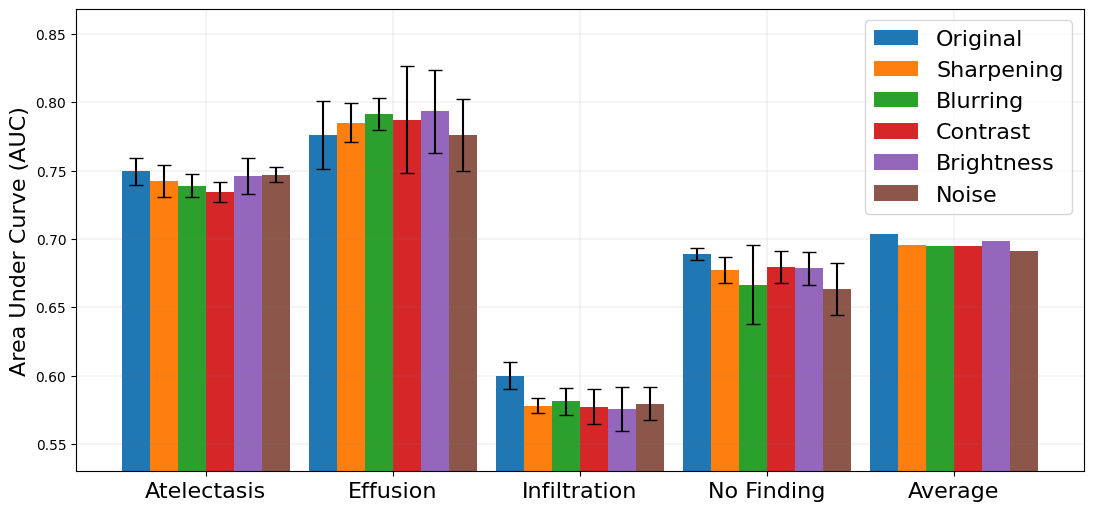

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_at.append(eval[0][0])
    original_ef.append(eval[0][1])
    original_in.append(eval[0][2])
    original_nf.append(eval[0][3])
original_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}
original_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}

sharpen_at, sharpen_ef, sharpen_in, sharpen_nf = [], [], [], []
for eval in evaluations_sharpness.values():
    sharpen_at.append(eval[0][0])
    sharpen_ef.append(eval[0][1])
    sharpen_in.append(eval[0][2])
    sharpen_nf.append(eval[0][3])
sharpen_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [sharpen_at, sharpen_ef, sharpen_in, sharpen_nf])}
sharpen_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [sharpen_at, sharpen_ef, sharpen_in, sharpen_nf])}

blur_at, blur_ef, blur_in, blur_nf = [], [], [], []
for eval in evaluations_blurr.values():
    blur_at.append(eval[0][0])
    blur_ef.append(eval[0][1])
    blur_in.append(eval[0][2])
    blur_nf.append(eval[0][3])
blur_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [blur_at, blur_ef, blur_in, blur_nf])}
blur_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [blur_at, blur_ef, blur_in, blur_nf])}

contrast_at, contrast_ef, contrast_in, contrast_nf = [], [], [], []
for eval in evaluations_contrast.values():
    contrast_at.append(eval[0][0])
    contrast_ef.append(eval[0][1])
    contrast_in.append(eval[0][2])
    contrast_nf.append(eval[0][3])
contrast_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [contrast_at, contrast_ef, contrast_in, contrast_nf])}
contrast_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [contrast_at, contrast_ef, contrast_in, contrast_nf])}

brightness_at, brightness_ef, brightness_in, brightness_nf = [], [], [], []
for eval in evaluations_brightness.values():
    brightness_at.append(eval[0][0])
    brightness_ef.append(eval[0][1])
    brightness_in.append(eval[0][2])
    brightness_nf.append(eval[0][3])
brightness_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [brightness_at, brightness_ef, brightness_in, brightness_nf])}
brightness_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [brightness_at, brightness_ef, brightness_in, brightness_nf])}

noise_at, noise_ef, noise_in, noise_nf = [], [], [], []
for eval in evaluations_noise.values():
    noise_at.append(eval[0][0])
    noise_ef.append(eval[0][1])
    noise_in.append(eval[0][2])
    noise_nf.append(eval[0][3])
noise_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [noise_at, noise_ef, noise_in, noise_nf])}
noise_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [noise_at, noise_ef, noise_in, noise_nf])}

performance = np.array([[original_means['at'], original_means['ef'], original_means['in'], original_means['nf']],
                        [sharpen_means['at'], sharpen_means['ef'], sharpen_means['in'], sharpen_means['nf']],
                        [blur_means['at'], blur_means['ef'], blur_means['in'], blur_means['nf']],
                        [contrast_means['at'], contrast_means['ef'], contrast_means['in'], contrast_means['nf']],
                        [brightness_means['at'], brightness_means['ef'], brightness_means['in'], brightness_means['nf']],
                        [noise_means['at'], noise_means['ef'], noise_means['in'], noise_means['nf']]])
row_averages = np.mean(performance, axis=1)
performance = np.column_stack((performance, row_averages))

std_dev = np.array([[original_stds['at'], original_stds['ef'], original_stds['in'], original_stds['nf'], np.NaN],
                    [sharpen_stds['at'], sharpen_stds['ef'], sharpen_stds['in'], sharpen_stds['nf'], np.NaN],
                    [blur_stds['at'], blur_stds['ef'], blur_stds['in'], blur_stds['nf'], np.NaN],
                    [contrast_stds['at'], contrast_stds['ef'], contrast_stds['in'], contrast_stds['nf'], np.NaN],
                    [brightness_stds['at'], brightness_stds['ef'], brightness_stds['in'], brightness_stds['nf'], np.NaN],
                    [noise_stds['at'], noise_stds['ef'], noise_stds['in'], noise_stds['nf'], np.NaN]])

print(np.mean(list(original_stds.values())))
print(np.mean(list(sharpen_stds.values())))
print(np.mean(list(blur_stds.values())))
print(np.mean(list(contrast_stds.values())))
print(np.mean(list(noise_stds.values())))

print()
print(row_averages)
print()

print(original_means)
print(sharpen_means)
print(contrast_means)
print(brightness_means)
print(noise_means)


labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['Original', 'Sharpening', 'Blurring', 'Contrast', 'Brightness', 'Noise']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.15  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(13, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.53)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.savefig("evals/augmentation/photometricAll_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

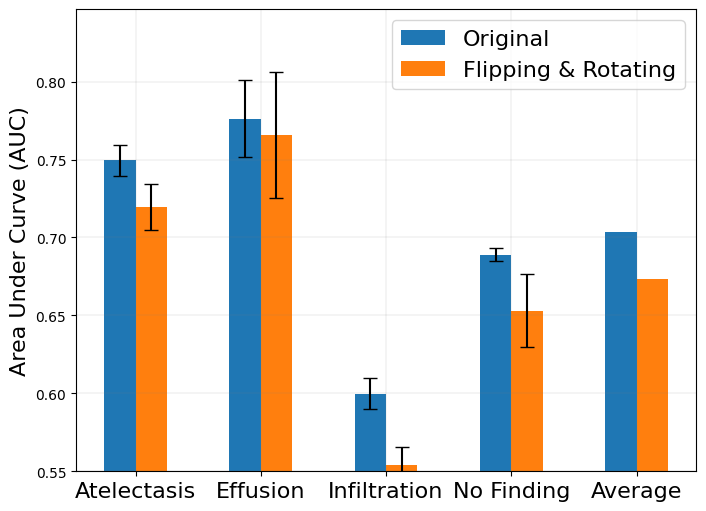

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_at.append(eval[0][0])
    original_ef.append(eval[0][1])
    original_in.append(eval[0][2])
    original_nf.append(eval[0][3])
original_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}
original_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_allPhotometric.values():
    horizontal_at.append(eval[0][0])
    horizontal_ef.append(eval[0][1])
    horizontal_in.append(eval[0][2])
    horizontal_nf.append(eval[0][3])
horizontal_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}
horizontal_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}

performance = np.array([[original_means['at'], original_means['ef'], original_means['in'], original_means['nf']],
                        [horizontal_means['at'], horizontal_means['ef'], horizontal_means['in'], horizontal_means['nf']]])
row_averages = np.mean(performance, axis=1)
performance = np.column_stack((performance, row_averages))

std_dev = np.array([[original_stds['at'], original_stds['ef'], original_stds['in'], original_stds['nf'], np.NaN],
                    [horizontal_stds['at'], horizontal_stds['ef'], horizontal_stds['in'], horizontal_stds['nf'], np.NaN]])


labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['Original', 'Flipping & Rotating']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.25  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.55)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.savefig("evals/augmentation/geometricCombined_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
with open(f"augmentation_data/images_test.pkl", "rb") as file:
    images_test = pickle.load(file)
with open(f"augmentation_data/labels_test.pkl", "rb") as file:
    labels_test = pickle.load(file)
    
master_evaluations = {}
BATCH_SIZE = 16
IMAGE_SIZE = 224



for aug_idx in range(4, 5):
    
    evaluations = {}
    
    images = None
    labels = None
    
    if aug_idx == 0:
        with open(f"augmentation_data/images_clean.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_clean.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 1:
        with open(f"augmentation_data/images_horizontal_flip.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_horizontal_flip.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 2:
        with open(f"augmentation_data/images_vertical_flip.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_vertical_flip.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 3:
        with open(f"augmentation_data/images_rotation.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_rotation.pkl", "rb") as file:
            labels = pickle.load(file)
    if aug_idx == 4:
        with open(f"augmentation_data/images_crop.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_crop.pkl", "rb") as file:
            labels = pickle.load(file)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for run, (train_idx, val_idx) in enumerate(skf.split(images, np.argmax(labels, axis=1))):
    
        tf.keras.backend.clear_session()
                
        images_train, images_val = images[train_idx], images[val_idx]
        labels_train, labels_val = labels[train_idx], labels[val_idx]
           
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        reduceLR_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=1e-7
        )
        
        model = create_resnet_model(IMAGE_SIZE)
                    
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=50,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping, reduceLR_callback]) #######BIRNE
        
        sub_eval = evaluate_model(model, images_test, labels_test)
        
        evaluations[run] = sub_eval
        print(aug_idx)
        print(evaluations)
        
    master_evaluations[aug_idx] = evaluations